In [313]:
!pip install d2l==1.0.0a1.post0

In [352]:
import os

import joblib as jb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torchvision
from d2l import torch as d2l
from torch import nn
from torchmetrics import R2Score


## Model Definition

In [315]:
class _SepConv1d(nn.Module):
    """A simple separable convolution implementation.

    The separable convlution is a method to reduce number of the parameters 
    in the deep learning network for slight decrease in predictions quality.
    """

    def __init__(self, ni, no, kernel, stride, pad):
        super().__init__()
        self.depthwise = nn.Conv1d(
            ni, ni, kernel, stride, padding=pad, groups=ni)
        self.pointwise = nn.Conv1d(ni, no, kernel_size=1)

    def forward(self, x):
        return self.pointwise(self.depthwise(x))


In [316]:
class SepConv1d(nn.Module):
    """Implementes a 1-d convolution with 'batteries included'.

    The module adds (optionally) activation function and dropout layers right after
    a separable convolution layer.
    """

    def __init__(self, ni, no, kernel, stride, pad, drop=None,
                 activ=lambda: nn.ReLU(inplace=True)):

        super().__init__()
        assert drop is None or (0.0 < drop < 1.0)
        layers = [_SepConv1d(ni, no, kernel, stride, pad)]
        if activ:
            layers.append(activ())
        if drop is not None:
            layers.append(nn.Dropout(drop))
        self.layers = nn.Sequential(*layers)

    def forward(self, x):
        return self.layers(x)


In [317]:
class Flatten(nn.Module):
    """Converts N-dimensional tensor into 'flat' one."""

    def __init__(self, keep_batch_dim=True):
        super().__init__()
        self.keep_batch_dim = keep_batch_dim

    def forward(self, x):
        if self.keep_batch_dim:
            return x.view(x.size(0), -1)
        return x.view(-1)


In [318]:
'''
# EXPERIMENTAL
class Classifier(nn.Module):
    def __init__(self, raw_ni, fft_ni, no, drop=.5):
        super().__init__()

        self.raw = nn.Sequential(
            SepConv1d(raw_ni,  32, 8, 2, 3, drop=drop),
            SepConv1d(32,  64, 8, 4, 2, drop=drop),
            SepConv1d(64, 128, 8, 4, 2, drop=drop),
            SepConv1d(128, 256, 8, 4, 2),
            Flatten(),
            nn.Dropout(drop), nn.Linear(256, 64), nn.ReLU(inplace=True),
            nn.Dropout(drop), nn.Linear(64, 64), nn.ReLU(inplace=True))

        self.fft = nn.Sequential(
            SepConv1d(fft_ni,  32, 8, 2, 4, drop=drop),
            SepConv1d(32,  64, 8, 2, 4, drop=drop),
            SepConv1d(64, 128, 8, 4, 4, drop=drop),
            SepConv1d(128, 128, 8, 4, 4, drop=drop),
            SepConv1d(128, 256, 8, 2, 3),
            Flatten(),
            nn.Dropout(drop), nn.Linear(256, 64), nn.ReLU(inplace=True),
            nn.Dropout(drop), nn.Linear(64, 64), nn.ReLU(inplace=True))

        self.out = nn.Sequential(
            nn.Linear(128, 64), nn.ReLU(inplace=True), nn.Linear(64, no))

    def forward(self, t_raw, t_fft):
        raw_out = self.raw(t_raw)
        fft_out = self.fft(t_fft)
        t_in = torch.cat([raw_out, fft_out], dim=1)
        out = self.out(t_in)
        return out
'''


'\n# EXPERIMENTAL\nclass Classifier(nn.Module):\n    def __init__(self, raw_ni, fft_ni, no, drop=.5):\n        super().__init__()\n\n        self.raw = nn.Sequential(\n            SepConv1d(raw_ni,  32, 8, 2, 3, drop=drop),\n            SepConv1d(32,  64, 8, 4, 2, drop=drop),\n            SepConv1d(64, 128, 8, 4, 2, drop=drop),\n            SepConv1d(128, 256, 8, 4, 2),\n            Flatten(),\n            nn.Dropout(drop), nn.Linear(256, 64), nn.ReLU(inplace=True),\n            nn.Dropout(drop), nn.Linear(64, 64), nn.ReLU(inplace=True))\n\n        self.fft = nn.Sequential(\n            SepConv1d(fft_ni,  32, 8, 2, 4, drop=drop),\n            SepConv1d(32,  64, 8, 2, 4, drop=drop),\n            SepConv1d(64, 128, 8, 4, 4, drop=drop),\n            SepConv1d(128, 128, 8, 4, 4, drop=drop),\n            SepConv1d(128, 256, 8, 2, 3),\n            Flatten(),\n            nn.Dropout(drop), nn.Linear(256, 64), nn.ReLU(inplace=True),\n            nn.Dropout(drop), nn.Linear(64, 64), nn.ReLU(inp

In [363]:
class Classifier(nn.Module):
    def __init__(self, raw_ni, no, drop=.5):
        super().__init__()

        self.net = nn.Sequential(
            # nn.Flatten(),
            nn.Linear(raw_ni, 2048),
            nn.Sigmoid(),
            nn.Linear(2048, 2048),
            nn.Sigmoid(),
            nn.Linear(2048, 2048),
            nn.Sigmoid(),
            nn.Linear(2048, no),
        )

    def forward(self, x):
        out = self.net(x)
        return out


In [320]:
# Calculating the loss
# loss = nn.CrossEntropyLoss(reduction='none')
loss = nn.MSELoss(reduction='none')


def evaluate_loss(data_iter, net, devices):
    l_sum, n = 0.0, 0
    for features, labels in data_iter:
        features, labels = features.to(devices[0]), labels.to(devices[0])
        outputs = net(features)
        l = loss(outputs, labels)
        l_sum += l.sum()
        n += labels.numel()
    return l_sum / n


In [321]:
# Defining the Training Function
def train(net, train_iter, valid_iter, num_epochs, lr, wd, devices, lr_period, lr_decay):

    net = nn.DataParallel(net, device_ids=devices).to(devices[0])
    trainer = torch.optim.SGD((param for param in net.parameters()
                               if param.requires_grad), lr=lr,
                              momentum=0.9, weight_decay=wd)
    scheduler = torch.optim.lr_scheduler.StepLR(trainer, lr_period, lr_decay)
    num_batches, timer = len(train_iter), d2l.Timer()
    legend = ['train loss']
    if valid_iter is not None:
        legend.append('valid loss')
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs],
                            legend=legend)
    for epoch in range(num_epochs):
        metric = d2l.Accumulator(2)
        for i, (features, labels) in enumerate(train_iter):
            timer.start()

            # print(features[0])
            # print(labels[0])

            features, labels = features.to(devices[0]), labels.to(devices[0])
            # features, labels = features.cuda(), labels.cuda()
            trainer.zero_grad()
            output = net(features)

            # print(f'epoch={epoch}: output={output}')

            l = loss(output, labels).sum()

            # print(f'epoch={epoch}: loss={l}')

            # break

            l.backward()
            trainer.step()
            metric.add(l, labels.shape[0])
            timer.stop()
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                             (metric[0] / metric[1], None))
            # torch.cuda.empty_cache()  # Helps avoid out-of-memory errors?
        measures = f'train loss {metric[0] / metric[1]:.3f}'
        if valid_iter is not None:
            valid_loss = evaluate_loss(valid_iter, net, devices)
            animator.add(epoch + 1, (None, valid_loss.detach().cpu()))
        scheduler.step()
    if valid_iter is not None:
        measures += f', valid loss {valid_loss:.3f}'
    print(measures + f'\n{metric[1] * num_epochs / timer.sum():.1f}'
          f' examples/sec on {str(devices)}')

    return net


## Prepare the datasets

**Load the previously-initialized datasets**

In [322]:
spo2_vals = jb.load('strided_dataset_spo2_vals.pk')


In [323]:
stride_dataset = jb.load('strided_dataset.pk')


In [324]:
dataset = pd.DataFrame.from_dict(stride_dataset).transpose()
dataset.head()


,0,1,2,3,4,5,6,7,8,9,...,462,463,464,465,466,467,468,469,470,471
0,"[0.03372104154178412, 0.03397176784514704, 0.0...","[0.04731305135860989, 0.04697857306417262, 0.0...","[0.03264586549525568, 0.03268662650254539, 0.0...","[0.04357170663524913, 0.039279179841498, 0.037...","[0.031851970311964205, 0.031107434161106437, 0...","[0.03986019626984409, 0.03929637549984271, 0.0...","[0.03282511309117019, 0.03527781220441398, 0.0...","[0.035912936286504195, 0.03467777418717162, 0....","[0.04377106091335317, 0.045851945830828515, 0....","[0.033072571319707894, 0.032919897481614786, 0...",...,"[0.032162507855820865, 0.032372882500816845, 0...","[0.037258913506823595, 0.03715192398722741, 0....","[0.03237275810305099, 0.032211187580555314, 0....","[0.038429344912384825, 0.03801394869358321, 0....","[0.03139547543730144, 0.03143103656403802, 0.0...","[0.03510589086291036, 0.03414388555401851, 0.0...","[0.032141706765738104, 0.03344910062722363, 0....","[0.03708469011064996, 0.035947146013096835, 0....","[0.03212565775730998, 0.03268221672720852, 0.0...","[0.03782007791220445, 0.03717689074631551, 0.0..."
1,"[0.052180152146382934, 0.0560367493194694, 0.0...","[0.03309772335235617, 0.03166751119813404, 0.0...","[0.05500736682231697, 0.0578087895162848, 0.05...","[0.02168649033807883, 0.0208397077806842, 0.02...","[0.05485601153072067, 0.049658875072782376, 0....","[0.028497891675333266, 0.027842856755506178, 0...","[0.036196317138285326, 0.03220027155339502, 0....","[0.018435764913356256, 0.027469660115215698, 0...","[0.0337251713947788, 0.031840145158706645, 0.0...","[0.03267519030787743, 0.04605598281838222, 0.0...",...,"[0.06066046289924655, 0.05758851583906523, 0.0...","[0.0313869440500196, 0.03005468853463802, 0.02...","[0.05374832312366484, 0.050127216007903846, 0....","[0.01798464704419525, 0.017431840816448028, 0....","[0.049160597594984735, 0.044529526569980334, 0...","[0.03037268369711297, 0.029224303251262594, 0....","[0.043046683247460006, 0.03575116139328748, 0....","[0.025013671777612597, 0.020730170219434026, 0...","[0.0404446705173963, 0.03613210450933765, 0.03...","[0.027045332262797775, 0.02603801138754177, 0...."
2,"[0.024557774370014128, 0.022284837039949486, 0...","[0.05032035178591479, 0.04258426369282614, 0.0...","[0.014331186543727305, 0.012543612693903375, 0...","[0.024099026482972477, 0.024439084553870918, 0...","[0.05244834538954765, 0.061058299350027656, 0....","[0.03714890993194224, 0.03443890833868782, 0.0...","[0.02628642171054967, 0.025576561889805723, 0....","[0.02609682162062108, 0.026056798174449086, 0....","[0.04900031873496176, 0.04740353782244562, 0.0...","[0.03474856963495425, 0.03327732475321049, 0.0...",...,"[0.05006476737232306, 0.04515892342774832, 0.0...","[0.03012050624601321, 0.027657712874887906, 0....","[0.02156352563651699, 0.020727639621658227, 0....","[0.03900533644501492, 0.05363256762838413, 0.0...","[0.04274133057528327, 0.03946763301249062, 0.0...","[0.025937991822347406, 0.024536094130741225, 0...","[0.021297838643334184, 0.020429108629605893, 0...","[0.06194172356970404, 0.06090341699960927, 0.0...","[0.03837564923320484, 0.03536118376798314, 0.0...","[0.023887632792863548, 0.023527735322563414, 0..."
3,"[0.043389370975970475, 0.06340548289586766, 0....","[0.024638065563935913, 0.02388210730785458, 0....","[0.05535896011925801, 0.04812067277194435, 0.0...","[0.025951290442527628, 0.02458399516851567, 0....","[0.04853952942142898, 0.04218039761999466, 0.0...","[0.019595775563279405, 0.02191843081342576, 0....","[0.028256413929607628, 0.027508997272458268, 0...","[0.03422009832781893, 0.04531519851948931, 0.0...","[0.02423751908144188, 0.024049561434740113, 0....","[0.06009972070633664, 0.06279138289271942, 0.0...",...,"[0.05547461809686946, 0.05040579669642153, 0.0...","[0.02468386481371841, 0.023285130567127034, 0....","[0.023500333098608304, 0.03365654551447295, 0....","[0.03569971842546504, 0.0330748103999321, 0.03...","[0.02564640483788606, 0.0249413325517764, 0.02...","[0.0561122

In [325]:
dataset_spo2 = pd.DataFrame.from_dict(spo2_vals).transpose()
dataset_spo2.head()


,0,1,2,3,4,5,6,7,8,9,...,462,463,464,465,466,467,468,469,470,471
0,97.0,97.0,97.0,97.0,97.0,97.0,97.0,97.0,97.0,97.0,...,97.0,97.0,97.0,97.0,97.0,97.0,97.0,97.0,97.0,97.0
1,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,...,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0
2,97.0,97.0,97.0,97.0,97.0,97.0,96.0,96.0,96.0,96.0,...,95.0,95.0,95.0,95.0,95.0,95.0,95.0,95.0,95.0,95.0
3,93.0,93.0,93.0,93.0,93.0,93.0,93.0,93.0,93.0,93.0,...,93.0,93.0,93.0,93.0,93.0,93.0,93.0,93.0,93.0,93.0
4,99.0,99.0,99.0,99.0,99.0,99.0,99.0,99.0,100.0,100.0,...,99.0,99.0,99.0,99.0,99.0,99.0,99.0,99.0,99.0,100.0


In [326]:
# convert percentage to decimal
dataset_spo2 = dataset_spo2/100


**Generate train and test datasets**

In [327]:
# split the data into train, validation, and test sets (80/10/10)
X_train, X_valid, X_test = np.split(dataset.sample(
    frac=1), [int(.8*len(dataset)), int(.9*len(dataset))])
y_train, y_valid, y_test = dataset_spo2.loc[X_train.index], dataset_spo2.loc[
    X_valid.index], dataset_spo2.loc[X_test.index]


In [330]:
# unroll the data
X_train_unrolled = []
y_train_unrolled = []
for r in X_train.index:
    for c in X_train.columns:
        # skip values containing NaN
        if not np.isnan(X_train.loc[r][c]).any() and not np.isnan(y_train.loc[r][c]):
            X_train_unrolled.append(X_train.loc[r][c])
            y_train_unrolled.append(y_train.loc[r][c])

X_valid_unrolled = []
y_valid_unrolled = []
for r in X_valid.index:
    for c in X_valid.columns:
        # skip values containing NaN
        if not np.isnan(X_valid.loc[r][c]).any() and not np.isnan(y_valid.loc[r][c]):
            X_valid_unrolled.append(X_valid.loc[r][c])
            y_valid_unrolled.append(y_valid.loc[r][c])

X_test_unrolled = []
y_test_unrolled = []
for r in X_test.index:
    for c in X_test.columns:
        # skip values containing NaN
        if not np.isnan(X_test.loc[r][c]).any() and not np.isnan(y_test.loc[r][c]):
            X_test_unrolled.append(X_test.loc[r][c])
            y_test_unrolled.append(y_test.loc[r][c])


In [331]:
# convert to tensors
X_train, y_train = torch.tensor(X_train_unrolled, dtype=torch.float32), torch.tensor(
    y_train_unrolled, dtype=torch.float32)
X_valid, y_valid = torch.tensor(X_valid_unrolled, dtype=torch.float32), torch.tensor(
    y_valid_unrolled, dtype=torch.float32)
X_test, y_test = torch.tensor(X_test_unrolled, dtype=torch.float32), torch.tensor(
    y_test_unrolled, dtype=torch.float32)


In [332]:
# reshape y tensors
y_train = y_train.reshape(-1, 1)
y_valid = y_valid.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)


In [333]:
# normalize x data
X_train_mean = X_train.mean()
X_train_std = X_train.std()
X_train = (X_train - X_train_mean) / (X_train_std + 1e-7)

X_valid_mean = X_valid.mean()
X_valid_std = X_valid.std()
X_valid = (X_valid - X_valid_mean) / (X_valid_std + 1e-7)

X_test_mean = X_test.mean()
X_test_std = X_test.std()
X_test = (X_test - X_test_mean) / (X_test_std + 1e-7)


In [334]:
# convert to torch iterators
batch_size = 64
train_iter = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(
    X_train, y_train), batch_size=batch_size, shuffle=True)
valid_iter = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(
    X_valid, y_valid), batch_size=batch_size, shuffle=True)
test_iter = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(
    X_test, y_test), batch_size=batch_size, shuffle=True)


## Train the model

In [341]:
num_epochs = 10
lr, wd = 1e-4, 1e-4
lr_period, lr_decay = 2, 0.9


In [336]:
# Training and Validating the Model
devices = d2l.try_all_gpus()
print(devices)  # check if CUDA is working


[device(type='cuda', index=0)]


In [337]:
torch.autograd.set_detect_anomaly(True)


train loss 0.001, valid loss 0.001
2719.0 examples/sec on [device(type='cuda', index=0)]


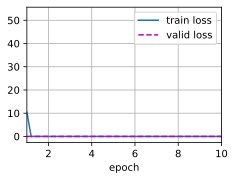

In [364]:
model = Classifier(240, 1, drop=.5)

# try linear model
# model = nn.Sequential(nn.Linear(240, 1))

model = train(model, train_iter, valid_iter, num_epochs,
              lr, wd, devices, lr_period, lr_decay)


In [365]:
# Save model
torch.save(model, f'./models/mlp_model.pt')


In [349]:
# Load model
model = torch.load(f'./models/mlp_model.pt')


In [366]:
# Get model's train accuracy
with torch.no_grad():
    # correct = 0
    total = 0
    r2 = R2Score().cuda()
    for features, labels in train_iter:
        features, labels = features.cuda(), labels.cuda()
        outputs = model(features)
        
        # classification
        # _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        # correct += (predicted == labels).sum().item()

        # regression
        r2.update(outputs, labels)

    print(
        f'R^2 accuracy of the model on the {total} train examples: {r2.compute():.2f}')


R^2 accuracy of the model on the 19702 train examples: -0.00


In [367]:
# Get model's train accuracy
with torch.no_grad():
    # correct = 0
    total = 0
    r2 = R2Score().cuda()
    for features, labels in test_iter:
        features, labels = features.cuda(), labels.cuda()
        outputs = model(features)

        # classification
        # _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        # correct += (predicted == labels).sum().item()

        # regression
        r2.update(outputs, labels)

    print(
        f'R^2 accuracy of the model on the {total} test examples: {r2.compute():.2f}')


R^2 accuracy of the model on the 2832 test examples: -0.12
